In [1]:
from scipy import io as spio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from IPython.display import clear_output
tfe = tf.contrib.eager # Shorthand for some symbols
tf.enable_eager_execution()

## Emnist
see https://arxiv.org/pdf/1702.05373v1.pdf for breakdown of dataset

In [2]:
# Load balanced letters dataset from csv
df_train = pd.read_csv("data/emnist-letters-train.csv")

# Data Shape
data shape of df_train is:

column 0 is the class

columns 1 to 785 are the image data

In [3]:
# get labels from first column
df_train_y = df_train.iloc[:,[0]]
# get 1d image data from other 784 columns
df_train_x = df_train.iloc[:, 1:785]

In [4]:
df_train_y.head()

,23
0,7
1,16
2,15
3,23
4,17


# Class transform
By default the Y classes are made up of 26 numbers each representing a letter of the alphabet,
as we only care about the characters 'm' and 'f', we will use a piecewise function to set anything that is not 'm' or 'f' to 0,
any class that is 'f' to 1, and any class that is 'm' to 2.

| class | mapping |
|-------|---------|
|   0   | unknown |
|   1   |    f    |
|   2   |    m    |

In [5]:
y = np.asarray(df_train_y)
train_y = np.piecewise(y, [(y != 6) & (y != 13), y == 6, y == 13], [0, 1, 2])

In [6]:
df_train_x.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Letter Data Transform
The training examples are 1d (1x784) and need to be resized to 28x28

In [7]:
train_x = df_train_x.values.reshape((88799, 28, 28))

Then the images need to be rotated 90 degrees, the 0th axis of our train_x is the image index itself, thus we only want to rotate axis 1 and 2 as they are the actual image data

The rot90 function is able to rotate an entire numpy matrix

In [8]:
train_x = np.fliplr(train_x)
train_x = np.rot90(train_x, axes=(2, 1))

# Plot F's and M's

5
50
51
65
74
99
126
129


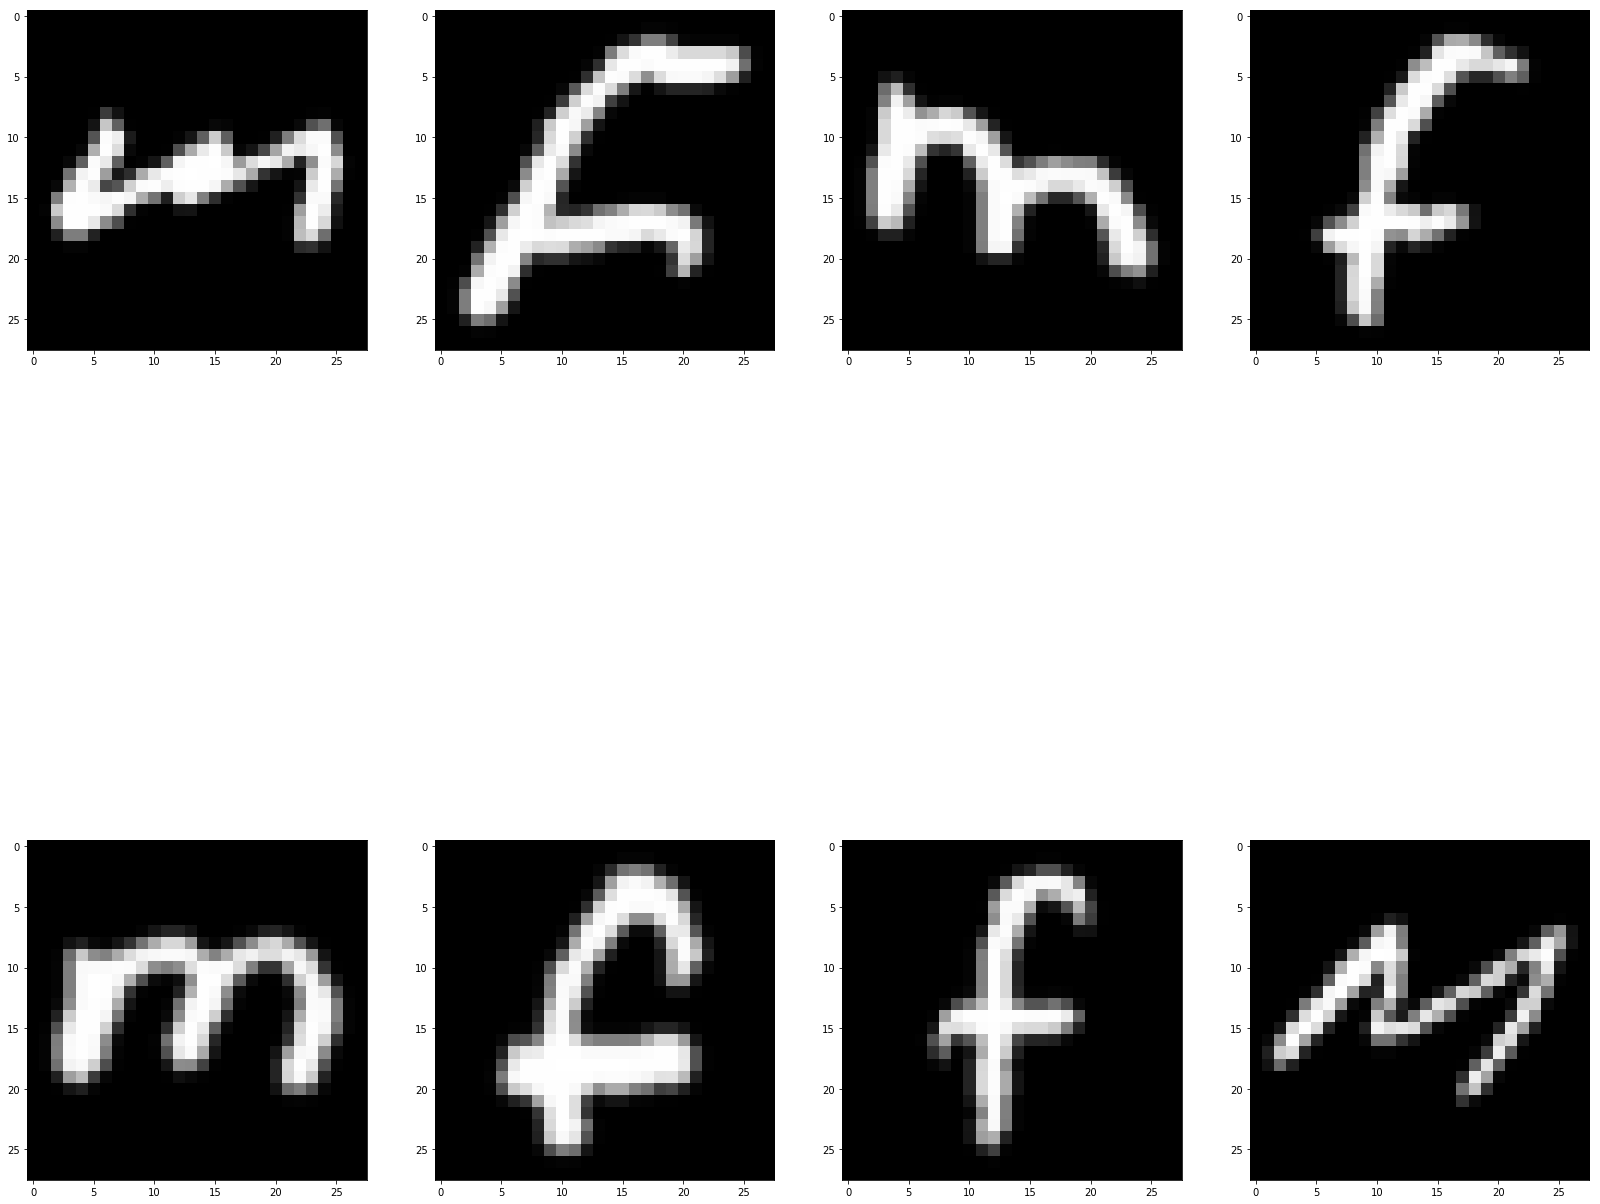

In [9]:
figure = plt.figure(figsize=(28, 28))
columns = 4
rows = 2
image_index = 0
for i in range(1, columns * rows + 1):
    figure.add_subplot(rows, columns, i)
    while train_y[image_index] == 0:
        image_index += 1
    print(image_index)
    plt.imshow(train_x[image_index], cmap='gray')
    image_index +=1

# Creating the Tensorflow model
The model is created similiar to the example given at https://www.tensorflow.org/guide/eager

The network is made up of several convolutional layers with maxpool layers inbetween

In [10]:
class MOFCnn(tf.keras.Model):
    def __init__(self):
        super(MOFCnn, self).__init__()
        # CNN layers
        self.cnn1 = tf.layers.Conv2D(32, 3, input_shape=(1, 28, 28), activation='relu', data_format="channels_first")
        self.cnn2 = tf.layers.Conv2D(64, 3, activation='relu', data_format="channels_first")
        self.cnn3 = tf.layers.Conv2D(128, 3, activation='relu', data_format="channels_first")
        
        # maxpool layers:
        self.maxpool = tf.layers.MaxPooling2D((2, 2), (2,2))
        
        # flatten layer:
        self.flatten = tf.layers.Flatten()
        
        # fully connected layers
        self.dense1 = tf.layers.Dense(10000, activation='relu')
        self.denseOutput = tf.layers.Dense(3, activation='softmax')
    
    def call(self, input):
        result = self.cnn1(input)
        result = self.maxpool(result)
        result = self.cnn2(result)
        result = self.maxpool(result)
        result = self.cnn3(result)
        result = self.maxpool(result)
        result = self.flatten(result)
        result = self.dense1(result)
        result = self.denseOutput(result)
        return result
    
    @staticmethod
    def loss(model, x, y):
        prediction = model(x)
        return tf.losses.softmax_cross_entropy(onehot_labels=y, logits=prediction)
    
    @staticmethod
    def grad(model, inputs, targets):
        with tf.GradientTape() as tape:
            loss_value = MOFCnn.loss(model, inputs, targets)
        return tape.gradient(loss_value, model.variables)
    
    @staticmethod
    def accuracy(predictions, labels):
        model_pred = tf.argmax(predictions, axis=1,output_type=tf.int64)
        actual_labels = tf.argmax(labels, axis=1, output_type=tf.int64)
        return tf.reduce_sum(tf.cast(tf.equal(model_pred, actual_labels),dtype=tf.float32)) / float(predictions.shape[0].value)

In [11]:
def trainMofCnn(model, x, y, batch_size, number_of_epochs):
    optimizer = tf.train.AdamOptimizer()
    x = tf.data.Dataset.from_tensor_slices(x)
    y = tf.data.Dataset.from_tensor_slices(y)
    data = tf.data.Dataset.zip((x, y)).batch(batch_size)
    for _ in range(number_of_epochs):
        for xs, ys in data:
            clear_output(True)
            grads = MOFCnn.grad(model, xs, ys)
            optimizer.apply_gradients(zip(grads, model.variables))
            loss = MOFCnn.loss(model, xs, ys)
            predictions = model(xs)
            print("loss: {:.3f}".format(loss))
            print(ys)
            print(tf.contrib.metrics.accuracy(predictions, ys))
        
        

# Formatting the training data
First the train X data needs to be converted from a numpy array of 64 bit integers in the 0-255 range, to a format that tensorflow understands; a tensor of 32 bit floats in the 0.0-1.0 range.

Fortunately tensorflow has a convenient helper function for this:

In [12]:
train_x = tf.image.convert_image_dtype([train_x], dtype=tf.float32)
train_x = tf.reshape(train_x, (-1, 1, 28, 28))
#x_float = tf.data.Dataset.from_tensor_slices(x_float)

In [13]:
train_y = tf.one_hot(train_y, 3, dtype=tf.int32)
train_y = tf.reshape(train_y, (-1, 3))

# Train Model

In [14]:
model = MOFCnn()

In [15]:
trainMofCnn(model, train_x, train_y, 2, 1)

loss: 1.086
tf.Tensor(
[[1 0 0]
 [1 0 0]], shape=(2, 3), dtype=int32)


ValueError: Dtypes of predictions and labels should match. Given: predictions (tf.float32) and labels (tf.int32)

In [53]:
tf.argmax(model(train_x[0:50]), axis=0)

<tf.Tensor: id=202237, shape=(3,), dtype=int64, numpy=array([0, 0, 0], dtype=int64)>

In [21]:
train_y[5]

<tf.Tensor: id=73315, shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>

In [43]:
model.variables

[<tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-0.12694576,  0.06382034,  0.13291192,  0.03130699,
            0.12868202, -0.01022779, -0.09062007,  0.14021184,
           -0.00259737,  0.07491334,  0.03258504,  0.00755625,
            0.07130665,  0.14182118,  0.08813372, -0.03113515,
           -0.0642942 ,  0.06004222, -0.08445195,  0.13330282,
            0.06034362,  0.09137145, -0.09948372,  0.06893794,
           -0.13363826, -0.06349997,  0.01761688, -0.10433002,
            0.039092  , -0.09855227,  0.03559849,  0.13322444]],
 
         [[-0.10258798,  0.0710118 ,  0.00601129, -0.07210329,
            0.0006314 , -0.09130789, -0.12212229,  0.10533248,
            0.10855576, -0.12090814, -0.11712475, -0.05703476,
            0.01385051, -0.02041751, -0.11272412, -0.03919879,
           -0.08920735, -0.04265847, -0.14184272,  0.13222198,
            0.06710298, -0.11460084,  0.13170195,  0.04836139,
           -0.09360765, -0.13627203,  